# Demo 3: AutoRegressive Conditional Heteroskedasticity Model

## Task 1: Read data

In [1]:
import pandas as pd

In [101]:
# Read csv data:
file_path = "/Users/user/AI_Class/Supervised/Regression/data_car_stock/BMW.DE.csv"
df_BMW = pd.read_csv(file_path) # read csv file to dataframe in pandas package

## Task 2: ARCH model for close time series data.
### Task 2.1: Check data properties

In [106]:
from statsmodels.tsa.stattools import acf,q_stat,adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import probplot, moment

from numpy import sqrt,std,subtract,polyfit,log

In [107]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0


In [108]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [4]:
# Prepare data for model
y_train = df_BMW["Close"][:1000]
y_test = df_BMW["Close"][1000:]
print(len(y_test))

266


In [102]:
df_BMW["Date"] = pd.to_datetime(df_BMW["Date"])
df_BMW = df_BMW.set_index("Date")

In [103]:
df_BMW.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-08-19,78.019997,78.190002,76.470001,77.320000,61.086472,1852903
2016-08-22,77.400002,78.449997,76.519997,76.949997,60.794147,1165052
2016-08-23,77.389999,77.970001,76.730003,77.480003,61.212883,1038967
2016-08-24,77.250000,78.029999,76.690002,77.510002,61.236576,971047
2016-08-25,76.800003,76.839996,75.599998,76.220001,60.217419,1490961


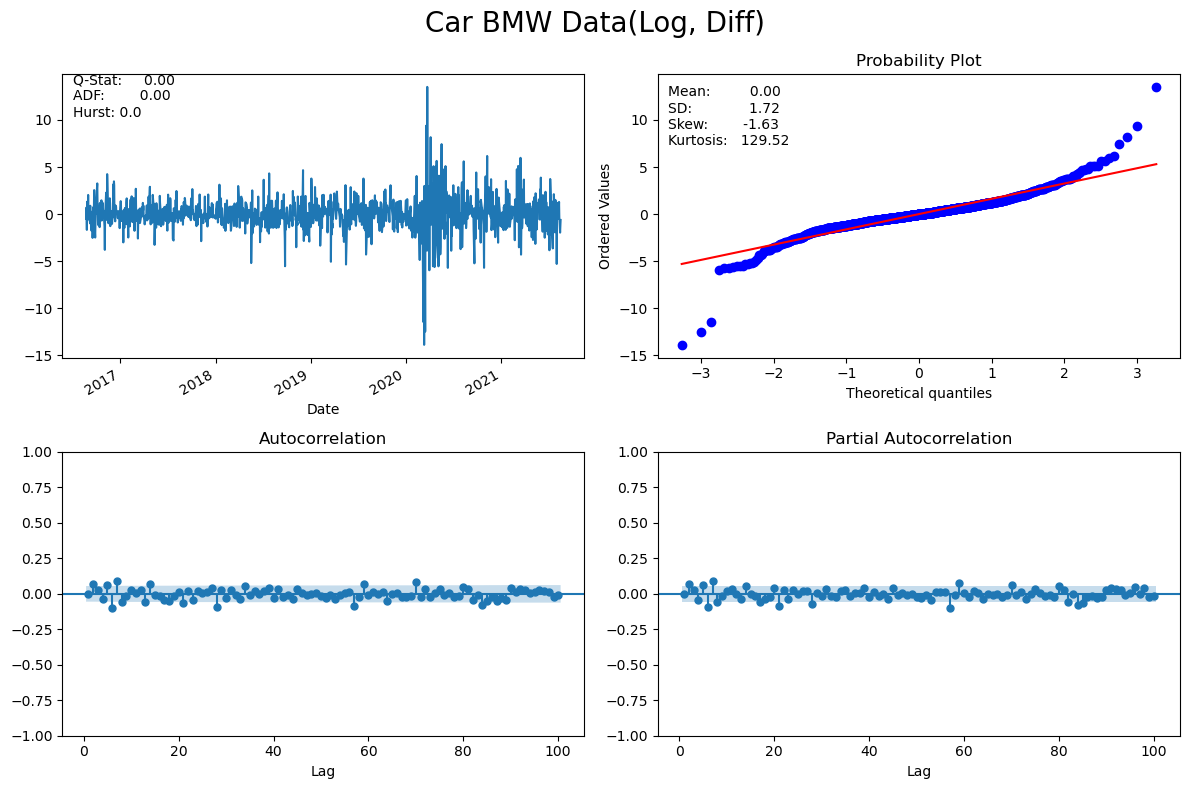

In [109]:
import numpy as np
# Calculate daily returns as percentage price changes
df_BMW['Return'] = 100 * (df_BMW['Close'].pct_change())
df_BMW['Log_Return'] = np.log(df_BMW['Close']).diff().mul(100) # rescale to faciliate optimization
df_BMW = df_BMW.dropna()

# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(df_BMW['Log_Return'], lags=100, title='Car BMW Data(Log, Diff)')

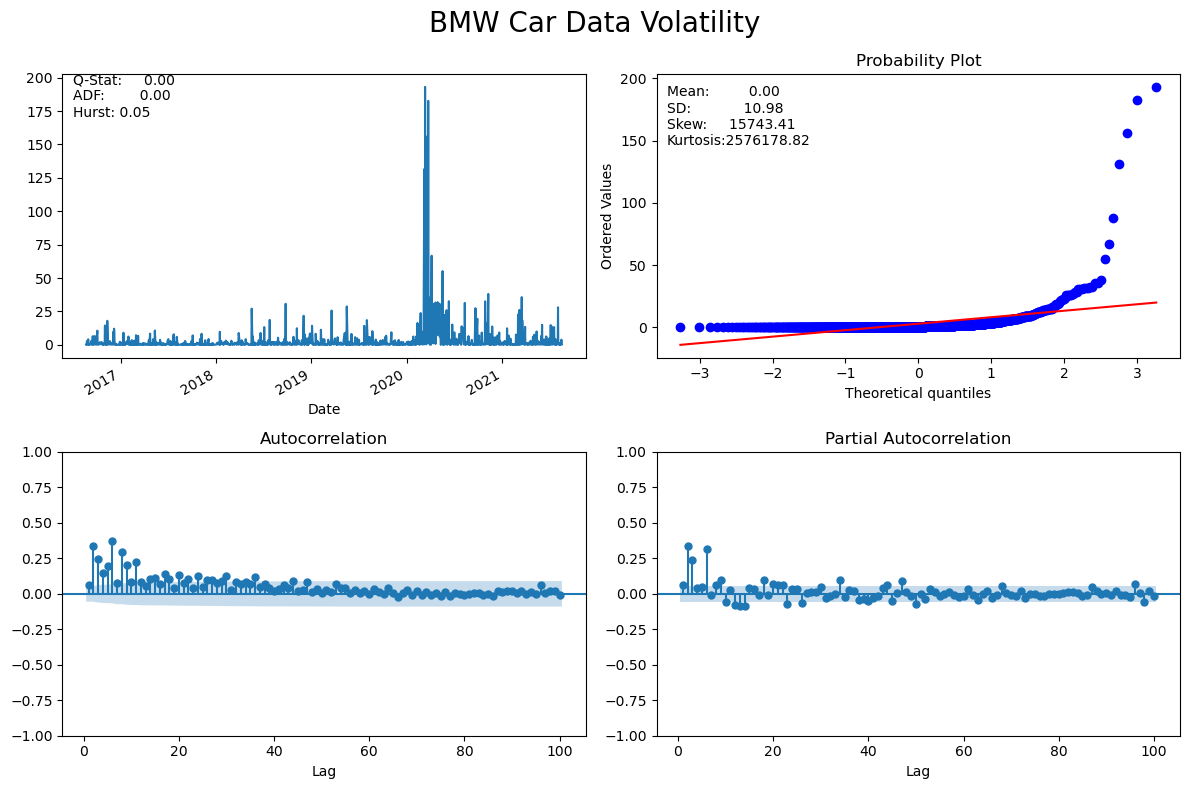

In [111]:
plot_correlogram(df_BMW['Log_Return'].sub(df_BMW['Log_Return'].mean()).pow(2), lags=100, title='BMW Car Data Volatility')

### Task 2.2: ARCH model:

In [112]:
from arch import arch_model
temp_arch = arch_model(df_BMW['Return'])


Alternatively, the same model ca be manually assembled from the building blocks of an ARCH model

'''

    from arch import ConstantMean,GARCH,Normal

    temp_arch = ConstantMean(df_BMW['Return'])

    temp_arch.volatility = GARCH(1,0,0)

    temp_arch.distribution = Normal()

'''

In [135]:
import datetime as dt
split_date = dt.datetime(2020,7,31,0,0)

In [129]:
temp_arch = arch_model(df_BMW['Return'],vol='Garch',p=1,o=0,q=0,dist='normal')

In [131]:
df_BMW['Return'].iloc[:1000]

Date
2016-08-22   -0.478535
2016-08-23    0.688767
2016-08-24    0.038718
2016-08-25   -1.664303
2016-08-26    1.325114
                ...   
2020-07-28    0.083680
2020-07-29   -2.525080
2020-07-30   -3.654145
2020-07-31   -2.599713
2020-08-03    2.760508
Name: Return, Length: 1000, dtype: float64

In [136]:
trained_arch = temp_arch.fit(last_obs=split_date)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3611.702696127548
Iteration:      2,   Func. Count:     13,   Neg. LLF: 5044.094512051368
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1937.6526846818754
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1889.868335070852
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1888.9375709942822
Iteration:      6,   Func. Count:     34,   Neg. LLF: 1888.9118136998168
Iteration:      7,   Func. Count:     38,   Neg. LLF: 1888.9039356984094
Iteration:      8,   Func. Count:     42,   Neg. LLF: 1888.903832134434
Iteration:      9,   Func. Count:     46,   Neg. LLF: 1888.9038309624766
Iteration:     10,   Func. Count:     49,   Neg. LLF: 1888.9038309624952
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1888.9038309624766
            Iterations: 10
            Function evaluations: 49
            Gradient evaluations: 10


<Axes: xlabel='Date'>

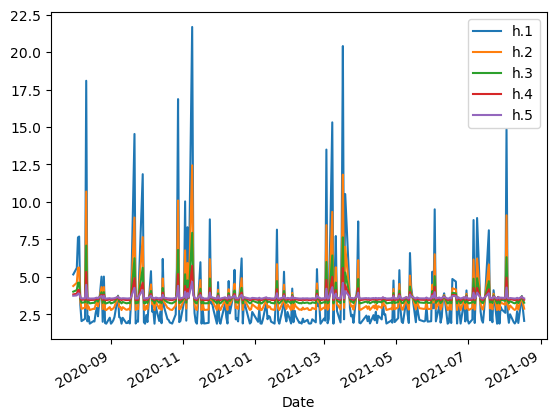

In [143]:
forecasts = trained_arch.forecast(horizon=5,start=split_date)
forecasts.variance[split_date:].plot()

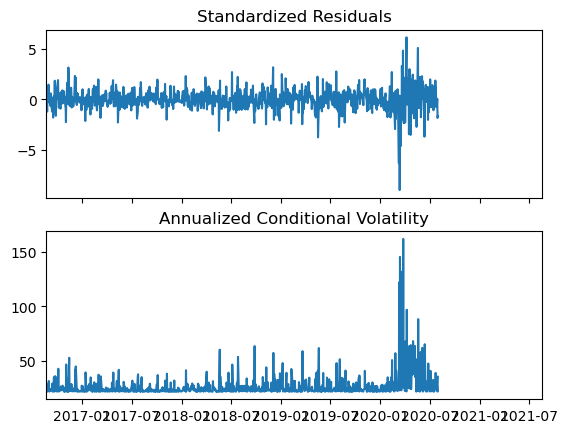

In [144]:
fig = trained_arch.plot(annualize="D")

In [117]:
parameters_df = pd.DataFrame(trained_arch.params)

In [118]:
parameters_df

,params
mu,0.022233
omega,0.056429
alpha[1],0.063304
beta[1],0.914729


In [121]:
simulate_model = arch_model(None,p=1,o=0,q=0,dist='normal',mean='Constant')

In [123]:
simulate_data = simulate_model.simulate(trained_arch.params,1000)

In [124]:
simulate_data.head()

,data,volatility,errors
0,-0.282386,0.237820,-0.304619
1,0.149472,0.249607,0.127239
2,0.645960,0.239696,0.623727
3,0.158566,0.284705,0.136333
4,-0.478372,0.240012,-0.500606
